### Reference

- [Anchor Boxes — The key to quality object detection (Medium)](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9)

- [Custom Dataset with Dataloader in Pytorch](https://towardsdev.com/custom-dataset-with-dataloader-in-pytorch-874e3cee63e2)

- [Anchor Boxes (DDL)](https://d2l.ai/chapter_computer-vision/anchor.html)

### Datasets

- [WIDER FACE: A Face Detection Benchmark](http://shuoyang1213.me/WIDERFACE/)

In [1]:
!pip install cython

In [2]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-3z1t99i3
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-3z1t99i3
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264330 sha256=7380eeaa2ede29f3c3372fc017291a237e3b5c92d3ff9c2840dad0e4aeebd1bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-e95uhvga/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [3]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
!unzip PennFudanPed.zip

--2022-05-09 10:35:40--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  22.2MB/s    in 2.3s    

2022-05-09 10:35:43 (22.2 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-05-09 10:35:43--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-05-09 10:35:43--
Total wall clock time: 2.7s
Downloaded: 1 files, 51M in 2.3s (22.2 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [4]:
import numpy as np
from PIL import Image
import os

import torch 
import torch.utils.data as data
from torch.utils.data import DataLoader
import tqdm as tqdm

import matplotlib.pyplot as plt

In [5]:
import random
lt = len(os.listdir('/content/PennFudanPed/PNGImages'))
print(lt)
random.randint(1, 10)

170


8

In [6]:
# def show_images(root):
#   lt = len(os.listdir(root))
#   num_1 = random.randint(1, 9)
#   num_11 = random.randint(10, lt)

#   img_1 = np.array(Image.open(os.path.join(root, 'PNGImages//PNGImages/FudanPed0000', num_1,'.png')))
#   img_2 = np.array(Image.open(os.path.join(root, 'PNGImages//PNGImages/FudanPed000', num_11,'.png')))
#   mk_1 = np.array(Image.open(os.path.join(root, 'PedMasks/FudanPed0000', num_1,'_mask.png')))
#   mk_11 = np.array(Image.open(os.path.join(root, 'PedMasks/FudanPed000', num_11,'_mask.png')))
#   plt.grid(False)
#   plt.axis('off')
#   axes = plt.subplot(2, 2)

#   axes[0, 0].imshow(img_1);
#   axes[0, 1].imshow(mk_1)

In [7]:
# show_images('/content/PennFudanPed/')

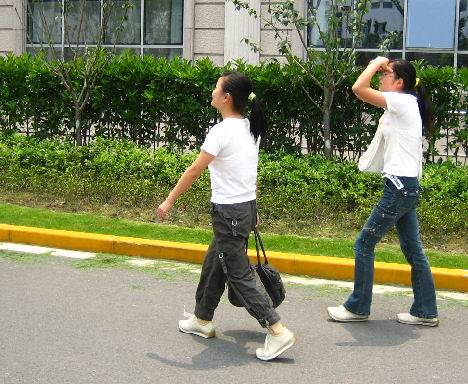

In [8]:
Image.open('/content/PennFudanPed/PNGImages/FudanPed00012.png')

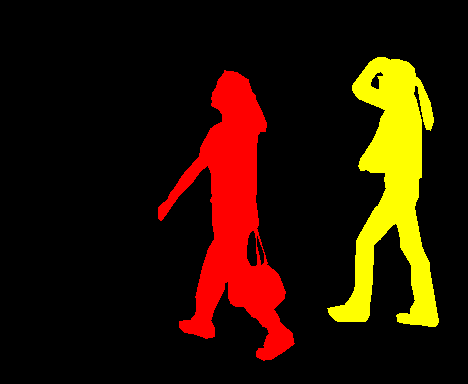

In [9]:
mask = Image.open('/content/PennFudanPed/PedMasks/FudanPed00012_mask.png')
# mask = np.array(mask)
mask.putpalette([
                 0, 0, 0,   #black background
                 255, 0, 0,     # index 1 is red
                 255, 255, 0,     # index 2 is yellow
                 255, 153, 0      # index 3 in orange
                 # Here indexes mean the number of objects that are there in the .png file
])
mask

In [10]:
# class PennFudanDataset(data.Dataset):
#   def __init__(self, root, transforms=None):
#     self.root = root
#     self.transforms = transforms

#     self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
#     self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

#   def __getitem__(self, idx):
#     img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
#     mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
#     img = Image.open(img_path).convert('RGB')

#     mask = Image.open(mask_path)
#     mask = np.array(mask)
#     obj_ids  = np.unique(mask)
#     obj_ids = obj_ids[1:]
    
#     #splitting the color encoded masks into a set of binary masks
#     masks = mask == obj_ids[:, None, None]

#     num_objs = len(obj_ids)
#     boxes = []
#     for i in range(num_objs):
#       pos = np.where(masks[i])
#       xmin = np.min(pos[1])
#       xmax = np.max(pos[1])
#       ymin = np.min(pos[0])
#       ymax = np.max(pos[0])
#       boxes.append([xmin, ymin, xmax, ymax])

#     #convert everthing into a torch.tensor
#     boxes = torch.as_tensor(boxes, dtype=torch.float32)
#     # there is only one class
#     labels = torch.ones((num_objs,), dtype=torch.int64)
#     masks = torch.as_tensor(masks, dtype=torch.uint8)

#     image_id = torch.tensor([idx])
#     area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#     # suppose all instances are not crowd
#     iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
#     target = {}
#     target['boxes'] = boxes
#     target['labels'] = labels
#     target['masks'] = masks
#     target['image_ids'] = image_id
#     target['area'] = area
#     target['iscrowd'] = iscrowd

#     if self.transforms is not None:
#       img, target = self.transforms(img, target)
#     return img, target
  
#   def __len__(self):
#     return len(self.imgs)

In [11]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [12]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FD54DC27ED0>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
print('in_feature (before): ', in_features)
num_classes = 2   # 1 class (person) + background
model_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print('in_features (after): ', model_rcnn.roi_heads.box_predictor)
```
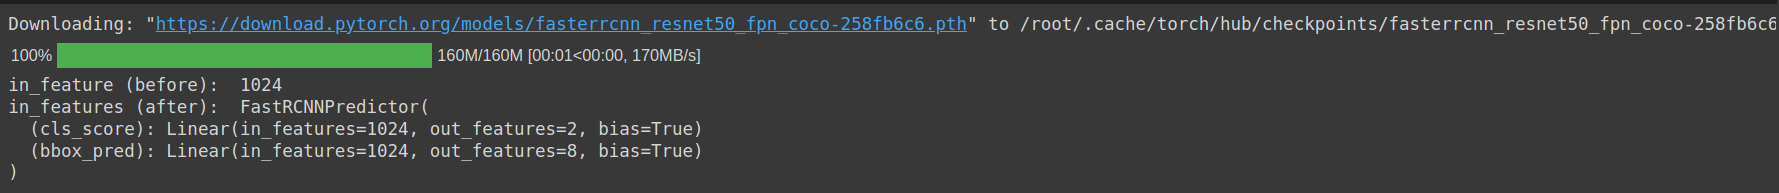




**My Understanding**
- We use a model for instance segmentation and another for classification

In [13]:
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn

def model_instance_segmentation(num_classes):

#   #Loading an pretrained instance segmentation model 
  model = maskrcnn_resnet50_fpn(pretrained=True)

#   #Getting & replacing #in_features for the classifier w/ a new one
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#   # Getting and replacing #in_features for the mask classifier w/ new one
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layers = 256

  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 
                                                     hidden_layers, 
                                                     num_classes)
  
  return model

In [14]:
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
# def get_instance_segmentation_model(num_classes):
#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

#     # get the number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

#     return model

In [15]:
%%shell

git clone https://github.com/pytorch/vision
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 133734, done.
remote: Counting objects: 100% (3021/3021), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 133734 (delta 2776), reused 2978 (delta 2760), pack-reused 130713
Receiving objects: 100% (133734/133734), 262.28 MiB | 11.30 MiB/s, done.
Resolving deltas: 100% (117405/117405), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [16]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def transform(train):
  transforms = []
  # converts the image, a PIL image, into a PyTorch Tensor
  transforms.append(T.ToTensor())
  if train:
    # during training, randomly flip the training images
    # and ground-truth for data augmentation
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [17]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import utils

model = fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', transform(train=True))
loader = DataLoader(dataset, batch_size=2, shuffle=True, 
                    num_workers=4, 
                    collate_fn=utils.collate_fn)

images, targets = next(iter(loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 300, 400)]
predictions = model(x)      #return predictions

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=2, shuffle=True, num_workers=4,
#     collate_fn=utils.collate_fn
# )
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions

In [19]:
from torch.utils.data import Subset

dataset = PennFudanDataset('PennFudanPed', transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', transform(train=False))

#train test splti
torch.manual_seed(42)
indices = torch.randperm(len(dataset)).tolist()
dataset = Subset(dataset, indices[:-50])
dataset_test = Subset(dataset_test, indices[-50:])

#defining training and validation dataloader
loader = DataLoader(dataset, batch_size=2, shuffle=True, 
                    num_workers=4, 
                    collate_fn=utils.collate_fn)
loader_test = DataLoader(dataset_test, batch_size=2, shuffle=True, 
                    num_workers=4, 
                    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
import torch.cuda as cuda
device = torch.device('cuda') if cuda.is_available() else torch.device('cpu')


from torch.optim.lr_scheduler import StepLR
num_classes = 2       #dataset has only 2 classes = person & background\

#Getting the model using helper function and 
# Moving the device to appropriate device
model = model_instance_segmentation(num_classes)
model.to(device)

#Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, 
                            momentum=0.9, weight_decay=0.0005)

#learning rate schedular
lr = StepLR(optimizer, step_size=3, gamma=0.1)
# lr = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
#                                                 steps_per_epoch=len(train_loader))

# epochs = 15
# max_lr = 0.01
# grad_clip = 0.1
# weight_decay = 1e-4
# opt_func = torch.optim.Adam



Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [21]:
from torch.optim import lr_scheduler
epochs = 10

for epoch in range(epochs):
  train_one_epoch(model, optimizer, loader, device, epoch, print_freq=10)
  lr.step()
  evaluate(model, loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:02:24  lr: 0.000090  loss: 5.6443 (5.6443)  loss_classifier: 0.5640 (0.5640)  loss_box_reg: 0.1633 (0.1633)  loss_mask: 4.9096 (4.9096)  loss_objectness: 0.0058 (0.0058)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 2.4072  data: 0.5638  max mem: 2090
Epoch: [0]  [10/60]  eta: 0:01:18  lr: 0.000936  loss: 1.4930 (2.6422)  loss_classifier: 0.3763 (0.3865)  loss_box_reg: 0.2243 (0.2427)  loss_mask: 0.9197 (1.9862)  loss_objectness: 0.0177 (0.0209)  loss_rpn_box_reg: 0.0048 (0.0058)  time: 1.5760  data: 0.0638  max mem: 2951
Epoch: [0]  [20/60]  eta: 0:01:01  lr: 0.001783  loss: 1.1442 (1.7739)  loss_classifier: 0.2467 (0.2995)  loss_box_reg: 0.2398 (0.2659)  loss_mask: 0.5121 (1.1847)  loss_objectness: 0.0134 (0.0165)  loss_rpn_box_reg: 0.0073 (0.0072)  time: 1.5007  data: 0.0130  max mem: 2951
Epoch: [0]  [30/60]  eta: 0:00:45  lr: 0.002629  loss: 0.6046 (1.3632)  loss_classifier: 0.1343 (0.2303)  loss_box_reg: 0.2260 (0.2438)  loss_mask: 0.2197 (0.8683)  loss_ob

In [29]:
img, _ = dataset_test[3]

model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

prediction

[{'boxes': tensor([[201.8339,  84.7011, 341.3453, 370.6333]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9977], device='cuda:0')}]

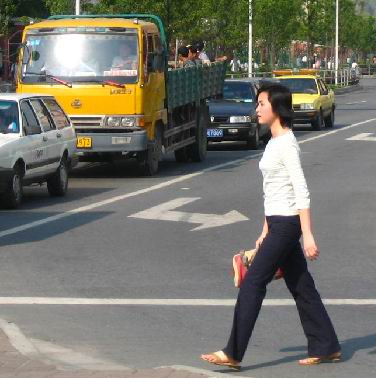

In [30]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

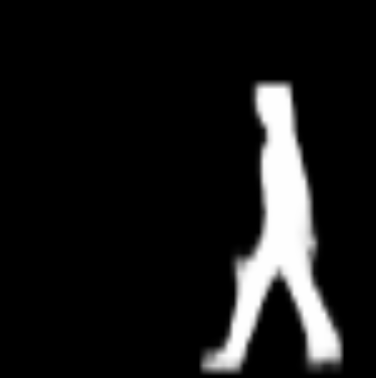

In [32]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [44]:
torch.save(model.state_dict(), '/content/sample_data/model.pth')